In [1]:
pip install numpy scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=b39102d5d382f33bf007f5f9fa06bcc2d4f8a2f896e1c5afc99c23434ea94d15
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


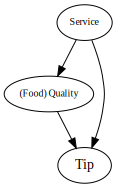

In [7]:
# The DAG representing the causal relatioships between Service Quality, Food Quality, and Tip

import graphviz

names = [
   "Service",
   "(Food) Quality",
]

g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")

g.edge("(Food) Quality", "Tip")
g.edge("Service", "Tip")
g.edge("Service", "(Food) Quality")
g

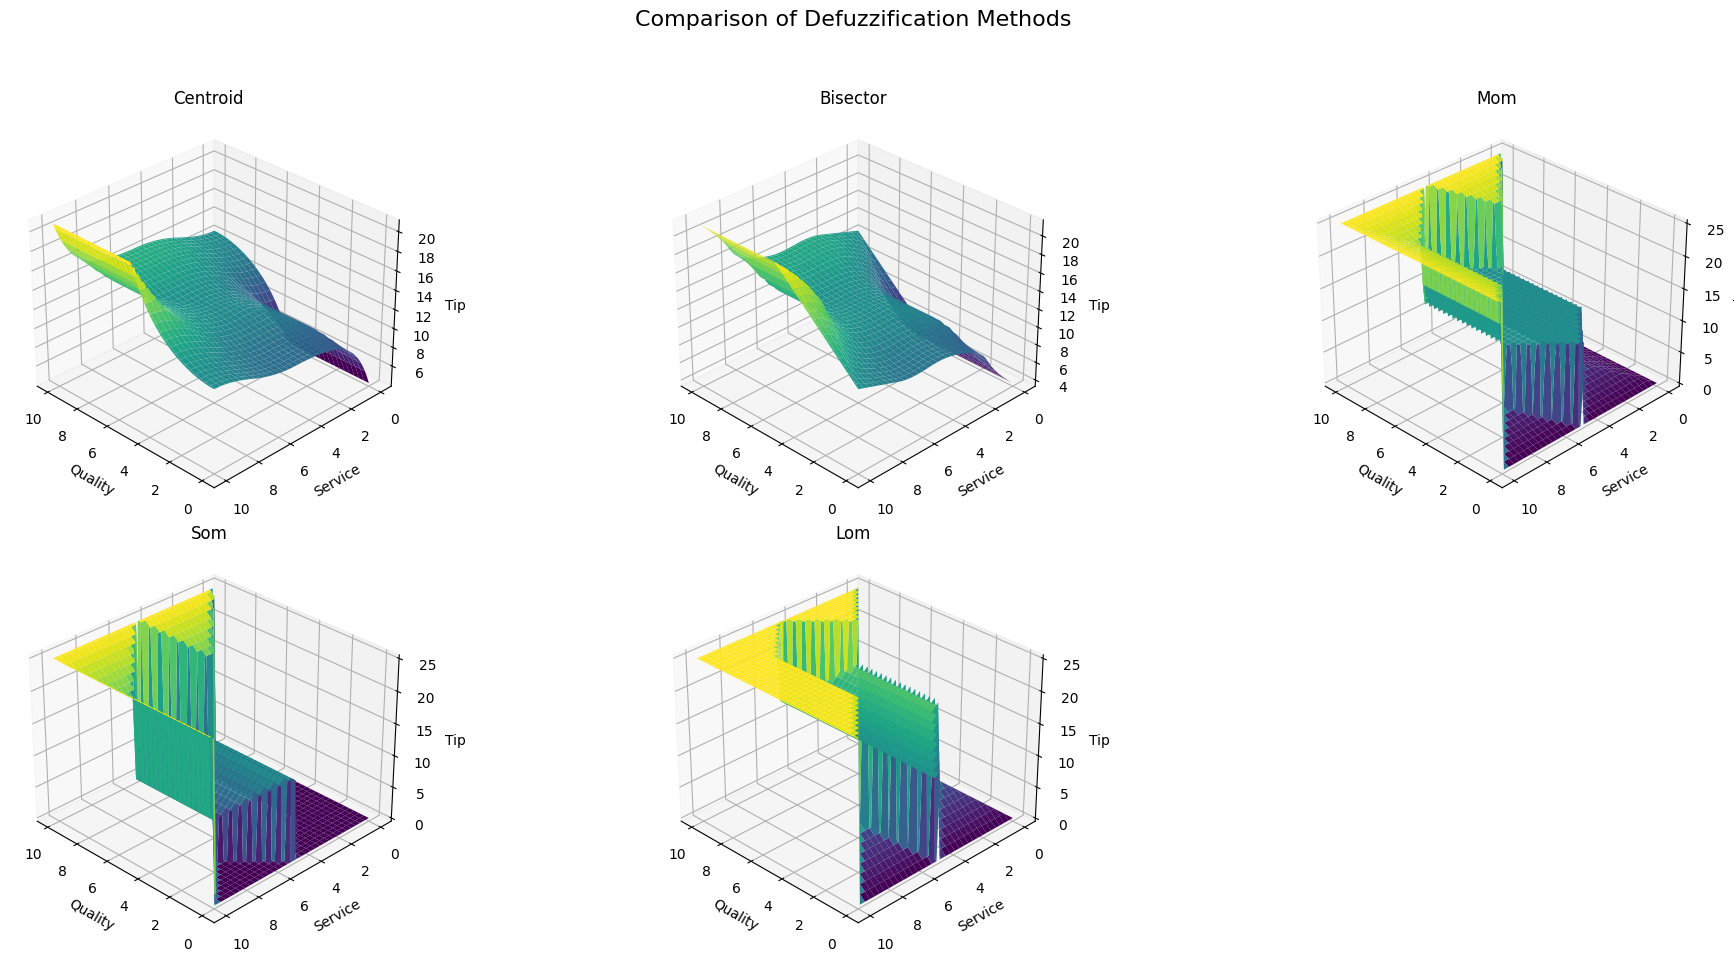

In [8]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Range of quality and service scores
step = 0.1
food_range = np.arange(0, 10 + step, step)
service_range = np.arange(0, 10 + step, step)

# Create fuzzy input variables
food = ctrl.Antecedent(food_range, 'food')
service = ctrl.Antecedent(service_range, 'service')

# Auto-membership functions
food.automf(3)
service.automf(3)

def setup_control_system(defuzz_method):
  # Create the fuzzy output
  tip = ctrl.Consequent(np.arange(0, 25 + step, step), 'tip', defuzzify_method = defuzz_method)

  # Custom membership functions for output variable
  tip['low'] = fuzz.trimf(tip.universe, [0, 0, 12.5])
  tip['medium'] = fuzz.trimf(tip.universe, [0, 12.5, 25])
  tip['high'] = fuzz.trimf(tip.universe, [12.5, 25, 25])

  # Fuzzy rules

  rule1 = ctrl.Rule(food['poor'] | service['poor'], tip['low'])
  rule2 = ctrl.Rule(service['average'], tip['medium'])
  rule3 = ctrl.Rule(service['good'] | food['good'], tip['high'])

  # Control system creation and simulation
  tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
  tipping = ctrl.ControlSystemSimulation(tipping_ctrl)
  return tipping

def simulate_tipping(tipping, food_range, service_range):
    results = np.zeros((len(food_range), len(service_range)))
    for i, q in enumerate(food_range):
        for j, s in enumerate(service_range):
            tipping.input['food'] = q
            tipping.input['service'] = s
            tipping.compute()
            results[i, j] = tipping.output['tip']
    return results

methods = ['centroid', 'bisector', 'mom', 'som', 'lom']
results = {}

# Simulate for each method
for method in methods:
    tipping = setup_control_system(method)
    results[method] = simulate_tipping(tipping, food_range, service_range)

# Prepare meshgrid for plotting
Q, S = np.meshgrid(food_range, service_range)

# Plot settings
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison of Defuzzification Methods', fontsize=16)

# Plot each method
for i, method in enumerate(methods):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    surf = ax.plot_surface(Q, S, results[method].T, cmap='viridis')

    ax.set_xlabel('Quality')
    ax.set_ylabel('Service')
    ax.set_zlabel('Tip')
    ax.set_title(method.capitalize())
    ax.view_init(elev=30, azim=135)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [9]:
# Define Gaussian distribution sampling for service
def sample_service(mu_service, sigma_service):
    service_sample = random.gauss(mu_service, sigma_service)
    return max(min(service_sample, 10), 0)

# Simulation parameters
mu_service, sigma_service = 7, 2  # mean and standard deviation for service
num_simulations = 1000

# Running the simulations
def expected_yq(tipping,q):
  total_tip = 0
  for _ in range(num_simulations):
    sampled_service = sample_service(mu_service, sigma_service)
    tipping.input['service'] = sampled_service
    tipping.input['food'] = q
    tipping.compute()
    total_tip += tipping.output['tip']
  return total_tip / num_simulations

Now, we use the following formula to calculate the FATE of Food Quality (Q) on Tip (T):

$$\mathrm{FATE}_l^h(T;Q):= \int_{-\infty}^{\infty}\mathbb{E}(T(q))\left(f_h(q) - f_l(q)\right)
\,\mathrm{d} q,$$
where
$$f_l(q) =\frac{\mu_{l}(q)}{\lVert low\rVert},\qquad f_h(q) =\frac{\mu_{h}(q)}{\lVert high\rVert},\quad \lVert low\rVert = \int \mu_l(q)\,\mathrm{d} q,\;\; \lVert high\rVert = \int \mu_h(q)\,\mathrm{d} q$$
Also, $\mu_l(q)$ and $\mu_h(q)$ are defined as it is shown in the following block of the code (here $l$ and $h$ stand for $low$ and $high$, respectively).

In [10]:
# Estimating the FATE of food quality on tip

import scipy.integrate as spi

def low(q):
  if 0 <= q <= 5:
    return -0.2*(q-5)
  else:
    return 0

def high(q):
  if 5 <= q <= 10:
    return 0.2*(q - 5)
  else:
    return 0

norm_low, _ = spi.quad(low, 0, 10)
norm_high, _ = spi.quad(high, 0, 10)

def integrand_low(tipping, q):
  return expected_yq(tipping,q) * low(q)/norm_low

def integrand_high(tipping,q):
  return expected_yq(tipping,q) * high(q)/norm_high

def FATE(tipping):
  expected_low = 0
  expected_high = 0
  for q in range(int(10/step)+1):
    point = step * q
    expected_low += integrand_low(tipping,point) * step
    expected_high += integrand_high(tipping,point) * step
  return expected_high - expected_low

FATE_all_methods = {}

for method in methods:
  tipping = setup_control_system(method)
  FATE_all_methods[method] = FATE(tipping)

FATE_all_methods

{'centroid': 3.420323559958593,
 'bisector': 3.574753502523583,
 'mom': 9.930257570419332,
 'som': 9.992186598218273,
 'lom': 9.941953843002452}

$$\mathrm{NFATE}_l^h(T;Q):= \frac{\mathrm{FATE}_l^h(T;Q)}{\mathbb{E}(Q-Q')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(T(q))\left(f_h(q) - f_l(q)\right)
	\,\mathrm{d} q}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (q-q')f_h(q)f_l(q')\, \mathrm{d}q'  \mathrm{d} q},$$
  where in $\mathbb{E}(Q-Q')$, $Q$ and $Q'$ come from the distributions based on $f_h$ and $f_l$, respectively.

In [11]:
# Estimating the NFATE of quality on tip

denominator = 0
for i in range(int(10/step)+1):
  for j in range(int(10/step)+1):
    point_1 = step * i
    point_2 = step * j
    denominator += (point_2  -  point_1) * low(point_1) * high(point_2) * (step**2)
denominator = denominator/(norm_low * norm_high)

NFATE_all_methods = {}
for method in methods:
  NFATE_all_methods[method] = FATE_all_methods[method]/denominator

NFATE_all_methods

{'centroid': 0.48824379617301655,
 'bisector': 0.5102883367198251,
 'mom': 1.4175228068820678,
 'som': 1.4263630417592106,
 'lom': 1.4191924245152971}

$$\mathrm{GFATE}_l^h(T;Q) = \int\mathbb{E}(T(q))(f_{\zeta_{Q,h}}(q)-f_{\zeta_{Q,l}}(q))\,\mathrm{d} q,$$
where
$$ f_{\zeta_{Q,h}}(q) = \frac{f_Q(q)\mu_h(q)}{\lVert generalized\_high\rVert}, \quad  f_{\zeta_{Q,l}}(q) = \frac{f_Q(q)\mu_l(q)}{\lVert generalized\_low\rVert},$$
where $f_Q$ is the probability density function of quality, and we have that  
$$\lVert generalized\_high\rVert = \int f_Q(q)\mu_h(q)\,\mathrm{d} q,\quad  \lVert generalized\_low\rVert = \int f_Q(q)\mu_l(q)\,\mathrm{d} q$$

In [ ]:
# Calculating the GFATE_l^h of quality on tip

from math import pi, sqrt, exp
import scipy.integrate as spi

mu_quality, sigma_quality = 5, 2

def density_quality(q):
  return (1/((sqrt(2*pi))*sigma_quality))*exp(-((q-mu_quality)**2)/(2*(sigma_quality**2)))

def generalized_low(q):
  return low(q) * density_quality(q)
def generalized_high(q):
  return high(q) * density_quality(q)

norm_generalized_low, _ = spi.quad(generalized_low, 0, 10)
norm_generalized_high, _ = spi.quad(generalized_high, 0, 10)

def generalized_integrand_low(tipping,q):
  return expected_yq(tipping,q) * low(q) * density_quality(q)/norm_generalized_low

def generalized_integrand_high(tipping,q):
  return expected_yq(tipping,q) * high(q) * density_quality(q)/norm_generalized_high

def GFATE(tipping):
  generalized_expected_low = 0
  generalized_expected_high = 0
  for q in range(int(10/step)+1):
    point = step * q
    generalized_expected_low += generalized_integrand_low(tipping,point) * step
    generalized_expected_high += generalized_integrand_high(tipping,point) * step
  return generalized_expected_high - generalized_expected_low

GFATE_all_methods = {}

for method in methods:
  tipping = setup_control_system(method)
  GFATE_all_methods[method] = GFATE(tipping)

GFATE_all_methods

{'centroid': 2.3310206469547143,
 'bisector': 2.172847993376193,
 'mom': 3.678776646306087,
 'som': 3.6467037260795916,
 'lom': 3.660807059807766}

$$\mathrm{NGFATE}_l^h(T;Q):= \frac{\mathrm{GFATE}_l^h(T;Q)}{\mathbb{E}(Q-Q')} = \frac{\int_{-\infty}^{\infty}\mathbb{E}(T(q))\left(f_{\zeta_{Q,h}}(q) - f_{\zeta_{Q,l}}(q)\right)
	\,\mathrm{d} q}{\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} (q-q')f_{\zeta_{S,h}}(q)f_{\zeta_{S,l}}(q')\, \mathrm{d}q'  \mathrm{d} q},$$
  where in $\mathbb{E}(Q-Q')$, $Q$ and $Q'$ come from the distributions based on $f_{\zeta_{Q,h}}$ and $f_{\zeta_{Q,l}}$, respectively.

In [ ]:
# Estimating the NGFATE of quality on tip

denominator = 0
for i in range(int(10/step)+1):
  for j in range(int(10/step)+1):
    point_1 = step * i
    point_2 = step * j
    denominator += (point_2  -  point_1) * low(point_1) * high(point_2) * (step**2)
denominator = denominator/(norm_low * norm_high)

NGFATE_all_methods = {}
for method in methods:
  NGFATE_all_methods[method] = GFATE_all_methods[method]/denominator

NGFATE_all_methods

{'centroid': 0.33274815954565096,
 'bisector': 0.3101693550904164,
 'mom': 0.525137415679722,
 'som': 0.5205590756334582,
 'lom': 0.522572296042998}